In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
import torchvision
import matplotlib.pyplot as plt

<h1>Train</h1>

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Random Seed
seed = 1234
torch.manual_seed(seed)

if device == 'cuda':
    torch.cuda.manual_seed_all(seed)

#Parameter
lr = 0.001
epochs = 15
batch_size = 100

In [4]:
#Data Loader
mnist_train = dsets.MNIST(root='MNIST__DATA/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST__DATA/',
                          train=False,
                          transform=transforms.ToTensor(),
                          download=True)

data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [5]:
#Model Define
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        
        self.fc = torch.nn.Linear(7*7*64, 10, bias=True)
        #이게 뭔지 찾기
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        #flatten
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [6]:
model = CNN().to(device)
#cost function and optimizer
cost_function = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

total_batch = len(data_loader)

In [24]:
#Train
for epoch in range(epochs):
    avg_cost = 0
    
    for X, Y in data_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        optimizer.zero_grad()
        predict = model(X)
        cost = cost_function(predict, Y)
        cost.backward()
        optimizer.step()
        
        avg_cost += cost / total_batch
    print('Epoch {0:>3}  loss = {1:<5}'.format(epoch+1, avg_cost))

#Save model
torch.save(model, 'model/model.pt')

Epoch   1  loss = 0.2231878787279129
Epoch   2  loss = 0.062485821545124054
Epoch   3  loss = 0.04657670855522156
Epoch   4  loss = 0.03861263394355774
Epoch   5  loss = 0.031364426016807556
Epoch   6  loss = 0.027409888803958893
Epoch   7  loss = 0.021661577746272087
Epoch   8  loss = 0.018389062955975533
Epoch   9  loss = 0.015153851360082626
Epoch  10  loss = 0.014429997652769089
Epoch  11  loss = 0.010299270041286945
Epoch  12  loss = 0.00904388353228569
Epoch  13  loss = 0.008121605031192303
Epoch  14  loss = 0.0061675976030528545
Epoch  15  loss = 0.007687471807003021


<h1>Test</h1>

In [7]:
#load model
model = torch.load('model/model.pt')
model.eval()

with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

C:\Users\user\anaconda3\Lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\user\anaconda3\Lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.9850999712944031


<h1>Actual Use</h1>

3


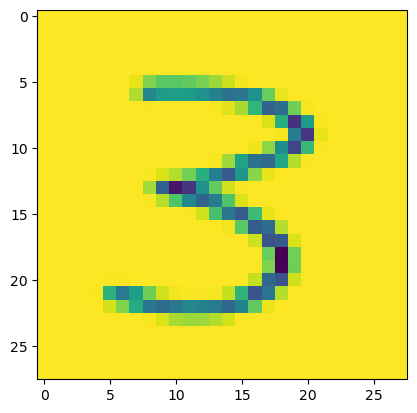

In [14]:
image_path = 'test_image/24.png'
img = torchvision.io.read_image(image_path, torchvision.io.ImageReadMode.GRAY)
img = transforms.Resize(size=(28, 28))(img)
plt.imshow(img.permute(1, 2, 0))
img = img.view(1, 1, 28, 28).float().to(device)

with torch.no_grad():
    prediction = model(img)
    print(torch.argmax(prediction, 1).item())